In [1]:
'''
# MNIST hand writing number classification by MLP of [in -> 128 -> 64 -> 32 -> 16 -> out]

Some techniques we use: 
  1. Kaiming initialization for Weights.
  2. Scale for softmax.
  3. Clip for cross entropy loss.
  4. Adam.
  5. Dropout. (TODO)

Effect(acc): 
  * 68.02% -> 97.15%
'''

import jax.numpy as jnp
from jax import grad, vmap, jit, random

import kagglehub
import matplotlib.pyplot as plt
import numpy as np

path = kagglehub.dataset_download("hojjatk/mnist-dataset")  # download mnist
key = random.PRNGKey(42)
print(f'mnsit at: {path}')

mnsit at: /home/tibless/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [2]:
# load mnist

import os
import struct
import numpy as np

def read_idx(filename):
    """
    Read MNIST data from file using idx format.

    Return
    ------
    np.ndarray
    """
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

TRAIN = 60000
TEST  = 10000
train_images = read_idx(os.path.join(path, 'train-images.idx3-ubyte'))[:TRAIN]
train_labels = read_idx(os.path.join(path, 'train-labels.idx1-ubyte'))[:TRAIN]
test_images = read_idx(os.path.join(path, 't10k-images.idx3-ubyte'))[:TEST]
test_labels = read_idx(os.path.join(path, 't10k-labels.idx1-ubyte'))[:TEST]

shuffle_kernel = np.random.permutation(np.arange(TRAIN))
train_images = train_images[shuffle_kernel]
train_labels = train_labels[shuffle_kernel]

print("训练图像数据大小: ", train_images.shape)
print("训练标签数据大小: ", train_labels.shape)
print("测试图像数据大小: ", test_images.shape)
print("测试标签数据大小: ", test_labels.shape)

训练图像数据大小:  (60000, 28, 28)
训练标签数据大小:  (60000,)
测试图像数据大小:  (10000, 28, 28)
测试标签数据大小:  (10000,)


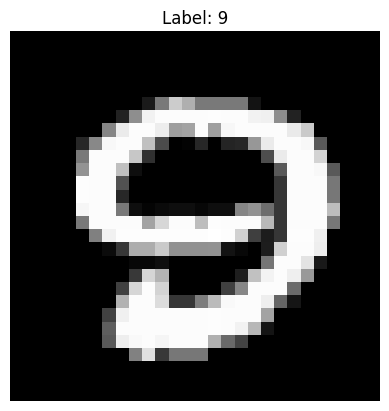

In [3]:
ix = 4
plt.imshow(train_images[ix], cmap='gray')
plt.title(f"Label: {train_labels[ix]}")
plt.axis('off')  # 不显示坐标轴
plt.show()

In [4]:
X_train = jnp.array(train_images.reshape(train_images.shape[0], -1)) / 255.  # normalization to accelerate training & convergency
y_train = jnp.array(train_labels)
X_test = jnp.array(test_images.reshape(test_images.shape[0], -1)) / 255.
y_test = jnp.array(test_labels)

def one_hot(y: jnp.ndarray, num_class: int):
    res = jnp.zeros((y.shape[0], num_class))
    res = res.at[jnp.arange(y.shape[0]), y].set(1)
    return res

y_train_one_hot = one_hot(y_train, 10)
y_test_one_hot = one_hot(y_test, 10)

In [5]:
# Softmax & Loss, version without improvement: 
# softmax = lambda logits: jnp.exp(logits) / jnp.sum(jnp.exp(logits), axis=1, keepdims=True)
# cross_entropy_loss = lambda y, y_pred: jnp.sum(-y * jnp.log(y_pred), axis=1).mean()

def softmax(logits):
    logits_stable = logits - jnp.max(logits, axis=1, keepdims=True)
    exp_logits = jnp.exp(logits_stable)
    return exp_logits / jnp.sum(exp_logits, axis=1, keepdims=True)

def cross_entropy_loss(y, y_pred):
    epsilon = 1e-9
    y_pred_clipped = jnp.clip(y_pred, epsilon, 1. - epsilon)  # clip here is very important, or you will get Nan when you training. 
    loss = -jnp.sum(y * jnp.log(y_pred_clipped), axis=1)
    return loss.mean()

class mlp_clf:
    def __init__(self, input_dim: int, hidden_dims: list, output_dim: int):
        self.Ws = []
        self.bs = []
        for prev, post in zip([input_dim] + hidden_dims, hidden_dims + [output_dim]):
            self.Ws.append(random.normal(key, (prev, post)) * jnp.sqrt(2 / prev))  # kaiming init
            self.bs.append(jnp.zeros(1))

        # Adam assistant variants initialization
        self.v_Ws = [jnp.zeros_like(w) for w in self.Ws]  # first-order momentum for each layer
        self.v_bs = [jnp.zeros_like(b) for b in self.bs]
        
        self.vv_Ws = [jnp.zeros_like(w) for w in self.Ws]  # second-order momentum for each layer
        self.vv_bs = [jnp.zeros_like(b) for b in self.bs]

        self.step = 0  # step of traing

    def predict_proba(self, Ws, bs, x_test: jnp.ndarray):
        res = x_test
        for w, b in zip(Ws, bs):
            res = res @ w + b
            res = jnp.maximum(0, res)  # use relu activation function

        return softmax(res)

    def _adam_update(self, gs, Ws, v_Ws, vv_Ws,
                    lr=0.01,
                    beta1=0.9,
                    beta2=0.999,
                    epsilon=1e-6):

        t = self.step + 1 # step of training, starting from 0, so add 1
        
        new_Ws, new_v_Ws, new_vv_Ws = [], [], []
        for g, w, v_w, vv_w in zip(gs, Ws, v_Ws, vv_Ws):
            new_v_w = beta1*v_w + (1 - beta1)*g
            new_vv_w = beta2*vv_w + (1 - beta2)*g*g

            v_w_hat = new_v_w / (1 - beta1**t)
            vv_w_hat = new_vv_w / (1 - beta2**t)
            step = - lr * v_w_hat / (jnp.sqrt(vv_w_hat) + epsilon)

            new_w = w + step

            new_Ws.append(new_w)
            new_v_Ws.append(new_v_w)
            new_vv_Ws.append(new_vv_w)

        return new_Ws, new_v_Ws, new_vv_Ws

    def _gd(self, gs, Ws, lr):
        new_Ws = []
        for g, w in zip(gs, Ws):
            step = -lr*g
            new_w = w + step
            new_Ws.append(new_w)

        return new_Ws

    def fit(self, x_train, y_train_proba, x_test, y_test_proba, 
            epoches=100, 
            lr=0.1,
            beta1=0.9,
            beta2=0.999,
            epsilon=1e-6): 
        
        def _acc(y_true_proba, y_pred_proba):
            y_true = jnp.argmax(y_true_proba, axis=1)
            y_pred = jnp.argmax(y_pred_proba, axis=1)
            return np.mean(y_true == y_pred)

        _loss = lambda Ws, bs: cross_entropy_loss(y_train_proba, softmax(self.predict_proba(Ws, bs, x_train))) 
        _loss = jit(_loss)  # accelerate loss function by JIT
        
        _tloss = lambda Ws, bs: cross_entropy_loss(y_test_proba, softmax(self.predict_proba(Ws, bs, x_test))) 
        
        acc, loss, tacc, tloss = [], [], [], []  # train acc, train loss, test acc, test loss
        
        for _ in range(epoches):
            loss.append(_loss(self.Ws, self.bs))
            tloss.append(_tloss(self.Ws, self.bs))

            d_ws = grad(_loss, argnums=0)(self.Ws, self.bs)
            d_bs = grad(_loss, argnums=1)(self.Ws, self.bs)

            # Adam
            self.Ws, self.v_Ws, self.vv_Ws = self._adam_update(d_ws, self.Ws, self.v_Ws, self.vv_Ws, lr, beta1, beta2, epsilon)
            self.bs, self.v_bs, self.vv_bs = self._adam_update(d_bs, self.bs, self.v_bs, self.vv_bs, lr, beta1, beta2, epsilon)

            # normal GD
            # self.Ws = self._gd(d_ws, self.Ws, lr)
            # self.bs = self._gd(d_bs, self.bs, lr)
            
            self.step += 1  # remember update step, all variants updated.
            
            acc.append(_acc(y_train_proba, self.predict_proba(self.Ws, self.bs, x_train)))
            tacc.append(_acc(y_test_proba, self.predict_proba(self.Ws, self.bs, x_test)))

        return acc, loss, tacc, tloss

mlp = mlp_clf(
    input_dim=X_train.shape[1],
    hidden_dims=[128, 64, 32, 16],
    output_dim=y_train_one_hot.shape[1]
)

epochs = 1000
acc, loss, tacc, tloss = mlp.fit(
    x_train=X_train, 
    y_train_proba=y_train_one_hot,
    x_test=X_test,
    y_test_proba=y_test_one_hot,
    epoches=epochs,
    lr=0.01)

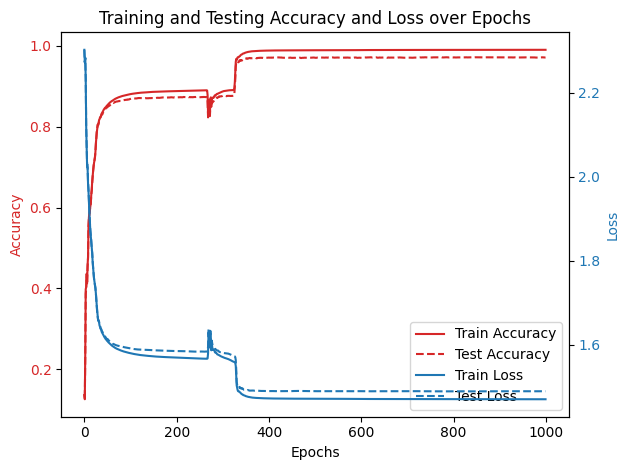

final train, test acc : 0.9904167056083679, 0.9714999794960022
final train, test loss: 1.4706674814224243, 1.4897372722625732


In [6]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(range(epochs), acc, color=color, label='Train Accuracy', linestyle='-')
ax1.plot(range(epochs), tacc, color=color, label='Test Accuracy', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  
ax2.plot(range(epochs), loss, color=color, label='Train Loss', linestyle='-')
ax2.plot(range(epochs), tloss, color=color, label='Test Loss', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='lower right')

plt.title('Training and Testing Accuracy and Loss over Epochs')
fig.tight_layout()
plt.show()

print(f'final train, test acc : {acc[-1]}, {tacc[-1]}')
print(f'final train, test loss: {loss[-1]}, {tloss[-1]}')